In [5]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
# Load and preprocess the data
dataset = pd.read_csv('/kaggle/input/mall-dataset/Mall_Customers.csv')
dataset = pd.read_csv('/kaggle/input/mall-dataset/Mall_Customers.csv')
dataset.head(5)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


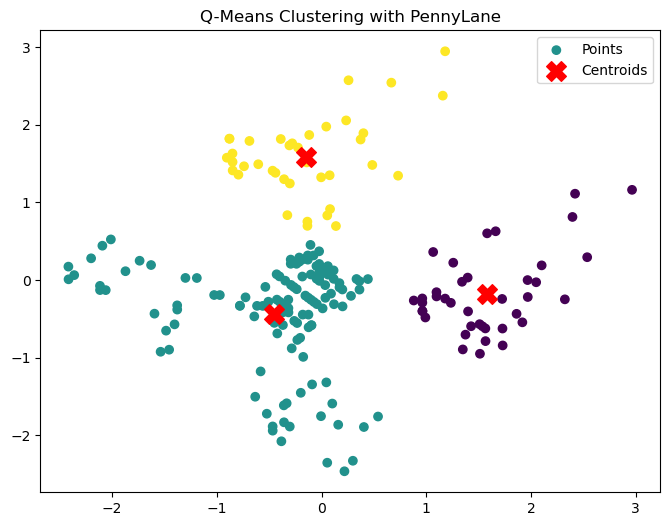

In [ ]:

X = dataset[['Annual Income (k$)', 'Spending Score (1-100)']].values

# Normalize and reduce dimensions
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# (Optional) Reduce to 2D for simplicity (quantum circuits handle fewer qubits efficiently)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Use only 2 dimensions for now
data = np.array(X_pca)

# Define a quantum device
dev = qml.device("default.qubit", wires=2)

# Angle embedding for data
def angle_embedding(x, wires):
    for i in range(len(x)):
        qml.RY(x[i], wires=wires[i])

# Define the quantum kernel between two points
@qml.qnode(dev)
def quantum_kernel(x, y):
    angle_embedding(x, wires=[0, 1])
    qml.adjoint(angle_embedding)(y, wires=[0, 1])
    return qml.probs(wires=[0, 1])

def quantum_distance(x, y):
    probs = quantum_kernel(x, y)
    return 1 - probs[0]  # Fidelity distance (1 - |⟨x|y⟩|²)

# Initialize centroids randomly
def initialize_centroids(data, k):
    np.random.seed(42)
    indices = np.random.choice(len(data), k, replace=False)
    return data[indices]

# Assign clusters based on quantum distance
def assign_clusters(data, centroids):
    clusters = []
    for x in data:
        distances = [quantum_distance(x, c) for c in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

# Update centroids
def update_centroids(data, clusters, k):
    new_centroids = []
    for i in range(k):
        points = data[clusters == i]
        if len(points) > 0:
            new_centroids.append(np.mean(points, axis=0))
        else:
            # Reinitialize if no points assigned
            new_centroids.append(data[np.random.randint(0, len(data))])
    return np.array(new_centroids)

# Q-means main loop
def qmeans(data, k=2, max_iters=10):
    centroids = initialize_centroids(data, k)
    for _ in range(max_iters):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, clusters, k)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return clusters, centroids

# Run Q-means
clusters, centroids = qmeans(data, k=3)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', label='Points')
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.title("Q-Means Clustering with PennyLane")
plt.legend()
plt.show()


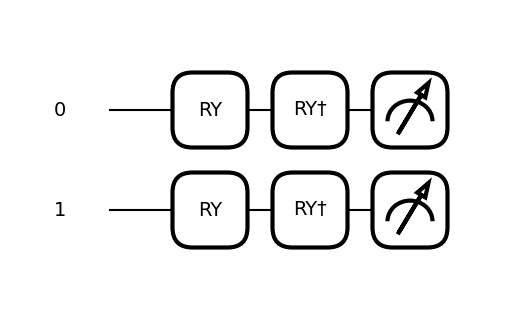

In [8]:
import matplotlib.pyplot as plt
from pennylane import draw_mpl

# Sample inputs for visualization
x_sample = [0.5, 1.2]
y_sample = [1.0, 0.8]

# Draw and plot the quantum circuit using matplotlib
fig, ax = draw_mpl(quantum_kernel)(x_sample, y_sample)
plt.show()
